In [1]:
import numpy as np
import zarr
from uuid import uuid4
import s3fs
import icechunk as ic
import os

In [2]:
NCORES = len(os.sched_getaffinity(0))
NCORES

zarr.config.set(
    {
        'threading.max_workers': NCORES,
        'async.concurrency': 128
    }
)

In [3]:
from contextlib import contextmanager
import time

class DiagnosticTimer:
    def __init__(self):
        self.diagnostics = []

    @contextmanager
    def time(self, **kwargs):
        tic = time.perf_counter()
        yield
        toc = time.perf_counter()
        kwargs["runtime"] = toc - tic
        self.diagnostics.append(kwargs)

    def dataframe(self):
        return pd.DataFrame(self.diagnostics)

diag_timer = DiagnosticTimer()

In [4]:
from functools import lru_cache
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Self
import tensorstore
import boto3

class AWSCredentialManager:
    """Complex workaround to allow us to pass AWS credentials to Tensorstore.
    Based on https://github.com/google/tensorstore/issues/148."""
    
    entries: dict[int, tuple[str, str]]
    folder_path: Path

    def __init__(self, folder_path: Path) -> None:
        self.entries = {}
        self.folder_path = folder_path

        self.credentials_file_path.touch()
        self.config_file_path.write_text("[default]\n")

    @property
    def credentials_file_path(self) -> Path:
        return self.folder_path / "credentials"

    @property
    def config_file_path(self) -> Path:
        return self.folder_path / "config"

    def _dump_credentials(self) -> None:
        self.credentials_file_path.write_text(
            "\n".join(
                [
                    (f"[profile-{key_hash}]\naws_access_key_id = {access_key_id}\naws_secret_access_key = {secret_access_key}\n"
                    f"aws_session_token = {token}")
                    for key_hash, (
                        access_key_id,
                        secret_access_key,
                        token
                    ) in self.entries.items()
                ]
            )
        )

    def add(self, access_key_id: str, secret_access_key: str, token: str) -> dict[str, str]:
        key_tuple = (access_key_id, secret_access_key, token)
        key_hash = hash(key_tuple)
        self.entries[key_hash] = key_tuple
        self._dump_credentials()
        return {
            "type": "profile",
            "profile": f"profile-{key_hash}",
            "config_file": str(self.config_file_path),
            "credentials_file": str(self.credentials_file_path),
        }

creds_dir = TemporaryDirectory()
creds_manager = AWSCredentialManager(Path(creds_dir.name))

In [5]:
N = 400_000_000
dtype = np.dtype('i8')
# random data is essentially incompressible;
# using random data is a "worst case scenario": we have all the costs of compression with none of the benefits
data = np.random.randint(low=np.iinfo(dtype).min, high=np.iinfo(dtype).max, dtype=dtype, size=N)
data.nbytes

3200000000

In [6]:
BUCKET = "ryan-sandbox-us-east-1"

In [7]:
NTRIALS = 5
COMPRESSION = True
FACTORS = [16, 64, 256, 1024, 4096]

In [8]:
def array_kwargs(factor, compression=False):
    if compression:
        compressors=zarr.codecs.ZstdCodec(level=3, checksum=False),
    else:
        compressors=[]

    return dict(
        shape=data.shape,
        chunks=data.shape[0]//factor,
        dtype=data.dtype, 
        compressors=compressors
    )

In [9]:
for _ in range(NTRIALS):
    for factor in FACTORS: 
        print(factor)
    
        apath = f's3://{BUCKET}/ryan_perf_test/{uuid4()}.zarr'
        a = zarr.create_array(store=apath, **array_kwargs(factor, compression=COMPRESSION))
    
        with diag_timer.time(nbytes=data.nbytes, chunksize=data.nbytes//factor, method="zarr-s3fs", mode="write"):
            a[:] = data
    
        with diag_timer.time(nbytes=data.nbytes, chunksize=data.nbytes//factor, method="zarr-s3fs", mode="read"):
            _ = a[:]

16
64
256
1024
4096
16
64
256
1024
4096
16
64
256
1024
4096
16
64
256
1024
4096
16
64
256
1024
4096


In [10]:
session = boto3.Session()
credentials = session.get_credentials()
creds = credentials.get_frozen_credentials()

In [11]:
from obstore.store import S3Store
from zarr.storage import ObjectStore

# obstore can't automatically detect credentials in the environment the way other libraries can
creds_kwargs = {
    "access_key_id": creds.access_key,
    "secret_access_key": creds.secret_key,
    "session_token": creds.token
}

for _ in range(NTRIALS):
    for factor in FACTORS: 
        print(factor)
    
        store = ObjectStore(S3Store(bucket=BUCKET, prefix=f'ryan_perf_test/{uuid4()}.zarr', config=creds_kwargs))
        a = zarr.create_array(store=store, **array_kwargs(factor, compression=COMPRESSION))

        with diag_timer.time(nbytes=data.nbytes, chunksize=data.nbytes//factor, method="zarr-obstore", mode="write"):
            a[:] = data
    
        with diag_timer.time(nbytes=data.nbytes, chunksize=data.nbytes//factor, method="zarr-obstore", mode="read"):
            _ = a[:]


16
64
256
1024
4096
16
64
256
1024
4096
16
64
256
1024
4096
16
64
256
1024
4096
16
64
256
1024
4096


In [12]:
storage = ic.s3_storage(
    bucket=BUCKET, prefix=f"ryan_perf_test/{uuid4()}.icechunk", from_env=True)
repo = ic.Repository.create(storage)

for _ in range(NTRIALS):
    for factor in FACTORS: 
        print(factor)
        session = repo.writable_session("main")
        group = zarr.group(session.store, zarr_format=3)
        a = group.create_array(f"a{factor}", **array_kwargs(factor, COMPRESSION))
    
        with diag_timer.time(nbytes=data.nbytes, chunksize=data.nbytes//factor, method="zarr-icechunk", mode="write", version=ic.__version__):
            a[:] = data
    
        with diag_timer.time(nbytes=data.nbytes, chunksize=data.nbytes//factor, method="zarr-icechunk", mode="read", version=ic.__version__):
            _ = a[:]

16
64
256
1024
4096
16
64
256
1024
4096
16
64
256
1024
4096
16
64
256
1024
4096
16
64
256
1024
4096


In [13]:
import tensorstore as ts

def make_tensorstore_array(path, dtype, shape, chunks, compression=False):

    codecs = ["bytes"]
    if compression:
        codecs.append({'name': 'zstd', 'configuration': {'level': 3, 'checksum': False}})

    kvstore = {
        "driver": "s3",
        "bucket": "ryan-sandbox-us-east-1",
        "path": f"ryan_perf_test/{uuid4()}.zarr",
        "aws_credentials": creds_manager.add(creds.access_key, creds.secret_key, creds.token),
        "s3_request_concurrency": {"limit": NCORES}
    }
    
    spec =  {
        'driver': 'zarr3',
        'kvstore': kvstore,
        "metadata": {
            "chunk_grid": {
                "configuration": {"chunk_shape": chunks},
                "name": "regular",
            },
            "codecs": codecs,
            "data_type": str(dtype),
            "shape": shape,
        },
        "create": True
    }
    
    return ts.open(spec).result()


In [14]:
for _ in range(NTRIALS):
    for factor in FACTORS: 
        print(factor)
    
        apath = f'ryan/{uuid4()}.zarr'
        tsa = make_tensorstore_array(apath, data.dtype, data.shape, (data.shape[0]//factor,), compression=COMPRESSION)
    
        with diag_timer.time(nbytes=data.nbytes, chunksize=data.nbytes//factor, method="tensorstore", mode="write"):
            tsa[:].write(data).result()
    
        with diag_timer.time(nbytes=data.nbytes, chunksize=data.nbytes//factor, method="tensorstore", mode="read"):
            _ = tsa[:].read().result()

16
64
256
1024
4096
16
64
256
1024
4096
16
64
256
1024
4096
16
64
256
1024
4096
16
64
256
1024
4096


In [15]:
import tiledb

cfg = tiledb.Config(
    {
        "vfs.s3.aws_access_key_id": creds.access_key,
        "vfs.s3.aws_secret_access_key": creds.secret_key,
        "vfs.s3.aws_session_token": creds.token,
        "vfs.s3.region": "us-east-1",
    }
)
tiledb.default_ctx(cfg)

tiledb.Ctx() [see Ctx.config() for configuration]

In [16]:
def make_tiledb_array(path, dtype, shape, chunks, compression=False):
    assert len(shape) == 1
    assert len(chunks) == 1
    dim = tiledb.Dim(name="d1", domain=(0, shape[0]-1), tile=chunks[0], dtype=np.int32)
    dom = tiledb.Domain(dim)
    a = tiledb.Attr(name="a", dtype=dtype)
    sch = tiledb.ArraySchema(domain=dom, sparse=False, attrs=[a])
    tiledb.Array.create(array_uri, sch)  # doesn't return anything

In [17]:
for _ in range(NTRIALS):
    for factor in FACTORS: 
        print(factor)

        array_uri = f"s3://{BUCKET}/ryan_perf_test/{uuid4()}.tiledb"
        make_tiledb_array(array_uri, data.dtype, data.shape, (data.shape[0]//factor,), compression=COMPRESSION)

        with tiledb.open(array_uri, "w") as a:
            with diag_timer.time(nbytes=data.nbytes, chunksize=data.nbytes//factor, method="tiledb", mode="write"):
                a[:] = data
    
        with tiledb.open(array_uri, "r") as a:
            with diag_timer.time(nbytes=data.nbytes, chunksize=data.nbytes//factor, method="tiledb", mode="read"):
                _ = a[:]

16
64
256
1024
4096
16
64
256
1024
4096
16
64
256
1024
4096
16
64
256
1024
4096
16
64
256
1024
4096


In [18]:
import pyarrow as pa
import pyarrow.parquet as pq

pa_array = pa.array(data)
table = pa.Table.from_arrays([pa_array], names=["values"])

In [19]:
for _ in range(NTRIALS):
    for factor in FACTORS:
        print(factor)
        output_path = f"s3://{BUCKET}/ryan_perf_test/{uuid4()}.parquet"
        row_group_size = data.nbytes//factor
        with diag_timer.time(nbytes=data.nbytes, chunksize=row_group_size, method="pyarrow-parquet", mode="write"):
            pq.write_table(table, output_path, row_group_size=row_group_size, compression="zstd")
        with diag_timer.time(nbytes=data.nbytes, chunksize=row_group_size, method="pyarrow-parquet", mode="read"):
            pq.read_table(output_path)

16
64
256
1024
4096
16
64
256
1024
4096
16
64
256
1024
4096
16
64
256
1024
4096
16
64
256
1024
4096


In [20]:
import polars as pl

pdf = pl.from_arrow(table)

In [21]:
for _ in range(NTRIALS):
    for factor in FACTORS:
        print(factor)
        output_path = f"s3://{BUCKET}/ryan_perf_test/{uuid4()}.parquet"
        row_group_size = data.nbytes//factor
        with diag_timer.time(nbytes=data.nbytes, chunksize=row_group_size, method="polars-parquet", mode="write"):
            pdf.write_parquet(output_path, row_group_size=row_group_size, compression="zstd")
        with diag_timer.time(nbytes=data.nbytes, chunksize=row_group_size, method="polars-parquet", mode="read"):
            pl.read_parquet(output_path)

16
64
256
1024
4096
16
64
256
1024
4096
16
64
256
1024
4096
16
64
256
1024
4096
16
64
256
1024
4096


In [22]:
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

In [23]:
df = diag_timer.dataframe()
df['Throughput (Gbps)'] = 8 * df.nbytes / df.runtime / int(1e9)
df['chunk size (MB)'] = df.chunksize / 1e6
df

,nbytes,chunksize,method,mode,runtime,version,Throughput (Gbps),chunk size (MB)
0,3200000000,200000000,zarr-s3fs,write,8.283232,NaN,3.090581,200.00000
1,3200000000,200000000,zarr-s3fs,read,4.792812,NaN,5.341332,200.00000
2,3200000000,50000000,zarr-s3fs,write,5.071470,NaN,5.047846,50.00000
3,3200000000,50000000,zarr-s3fs,read,4.038511,NaN,6.338969,50.00000
4,3200000000,12500000,zarr-s3fs,write,8.829057,NaN,2.899517,12.50000
...,...,...,...,...,...,...,...,...
345,3200000000,12500000,polars-parquet,read,2.137597,NaN,11.976062,12.50000
346,3200000000,3125000,polars-parquet,write,9.059681,NaN,2.825706,3.12500
347,3200000000,3125000,polars-parquet,read,2.174814,NaN,11.771119,3.12500
348,3200000000,781250,polars-parquet,write,7.969138,NaN,3.212393,0.78125


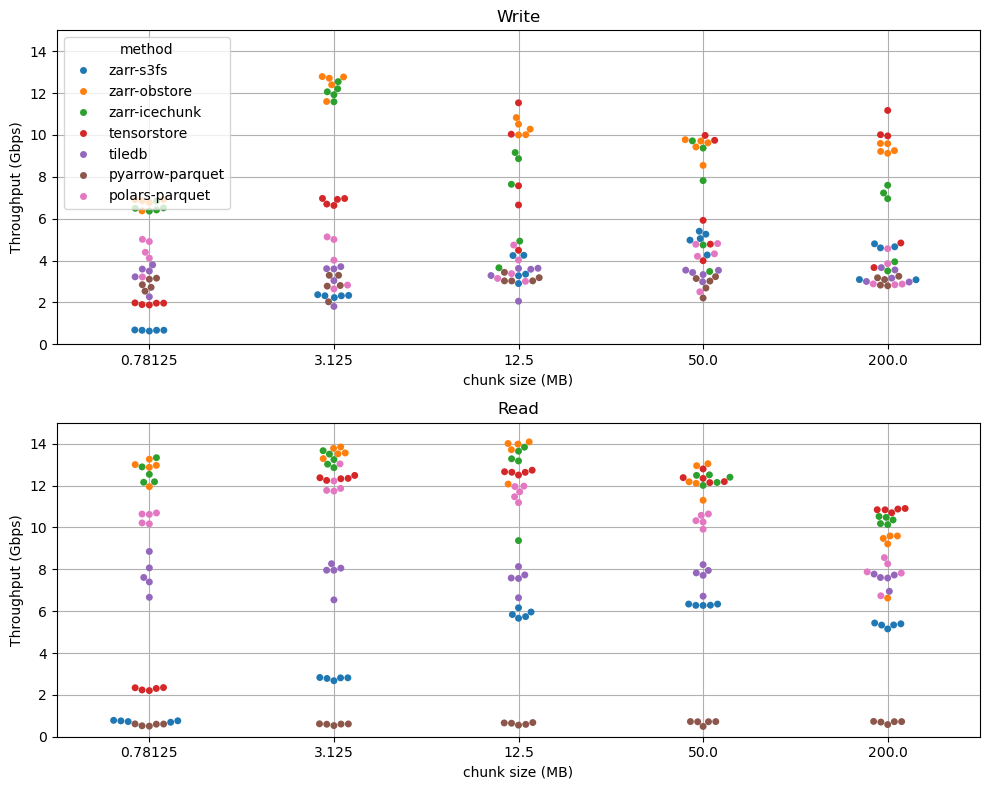

In [26]:
fig, axs = plt.subplots(nrows=2, figsize=(10, 8))

sns.swarmplot(data=df[df['mode']=="write"], x="chunk size (MB)", y="Throughput (Gbps)", hue="method", ax=axs[0])
axs[0].set_title("Write")
axs[0].grid()
axs[0].set_ylim([0, 15])


sns.swarmplot(data=df[df['mode']=="read"], x="chunk size (MB)", y="Throughput (Gbps)", hue="method", ax=axs[1], legend=False)
axs[1].set_title("Read")
axs[1].grid()
axs[1].set_ylim([0, 15])

fig.tight_layout()


In [25]:
df.to_csv("results-8xlarge-3.csv", index=False)